In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import spearmanr, pearsonr
import os, re, sys
from tqdm.notebook import tqdm
sys.path.append("../src")

import torch
import pyro
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch

In [2]:
import metagnn as mg

%load_ext autoreload
%autoreload 2

In [342]:
config = mg.tl.MetaGNNConfig(
    batch_size = 8,
    hidden_dim = 128,
    latent_dim = 2,
    num_layers = 2,
    num_components = 2,
    learning_rate = .05,
    num_epochs = 15,
    num_workers = 1,
    save_interval=5,
    k = 7, # k=10 1B params, k=9 200M params, k=8 72M params
)
# mg.tl.train_metagnn("../data/refseq_viruses.fasta", config)

Loading fasta: 0it [00:00, ?it/s]

2024-11-27 09:15:32,339 | INFO : Loading precomputed ANI JSON from ./_metagnn/combined_ani.json.gz...


Building graphs:   0%|          | 0/30 [00:00<?, ?it/s]

2024-11-27 09:15:33,581 | INFO : 1707143 paramter model


Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

2024-11-27 09:15:37,316 | INFO : Checkpoint model saved at epoch 0
2024-11-27 09:15:56,885 | INFO : Checkpoint model saved at epoch 5
2024-11-27 09:16:16,191 | INFO : Checkpoint model saved at epoch 10
2024-11-27 09:16:35,592 | INFO : Checkpoint model saved at epoch 15
2024-11-27 09:16:54,960 | INFO : Checkpoint model saved at epoch 20
2024-11-27 09:17:14,635 | INFO : Checkpoint model saved at epoch 25
2024-11-27 09:17:33,177 | INFO : Checkpoint model saved at epoch 30
2024-11-27 09:17:52,032 | INFO : Checkpoint model saved at epoch 35
2024-11-27 09:18:11,142 | INFO : Checkpoint model saved at epoch 40
2024-11-27 09:18:30,706 | INFO : Checkpoint model saved at epoch 45


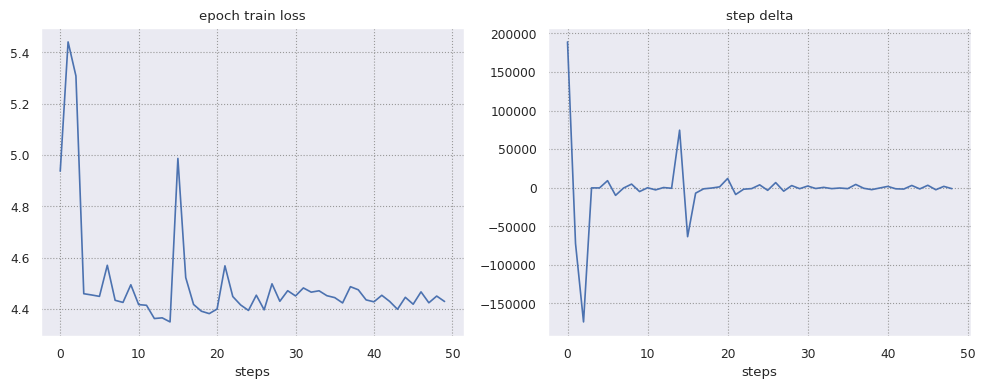

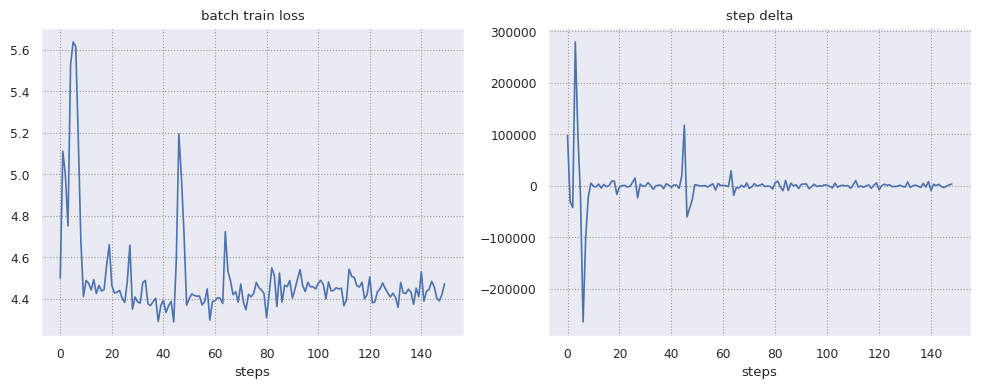

In [502]:
config.num_epochs = 50
mg.tl.train_metagnn("../data/combined.fasta", config)

In [397]:
dataset = mg.tl.MetagenomeDataset("../data/combined.fasta", config, train=True)
dataset.train=True
dataloader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    collate_fn=dataset.metagenome_collate_fn,
    shuffle=True,
    drop_last=True,
)

Loading fasta: 0it [00:00, ?it/s]

2024-11-27 08:32:35,601 | INFO : Loading precomputed ANI JSON from ./_metagnn/combined_ani.json.gz...


Building graphs:   0%|          | 0/30 [00:00<?, ?it/s]

In [431]:
sample_batch = next(iter(dataloader))

Reconstruction progress:   0%|          | 0/4 [00:00<?, ?it/s]

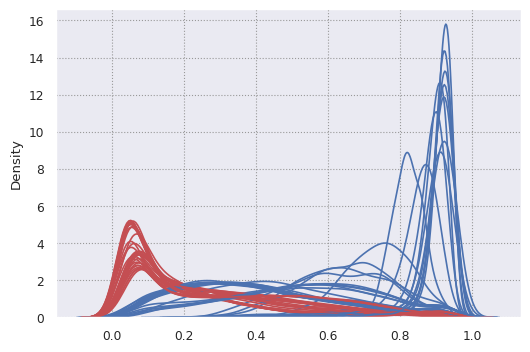

In [503]:
vae = mg.tl.load_model("20241127-091533")
mg.pl.reconstruction(dataset, vae)

In [48]:
num_nodes = 4**(config.k-1)
num_edges = sample_batch["graphs"].get_example(6).edge_index.size(1)
max_possible_edges = num_nodes * (num_nodes - 1) / 2 
1 - (num_edges / max_possible_edges)

0.9988966870802808

In [21]:

# Flatten matrices (exclude diagonal elements)
def flatten_matrix(mat):
    # Extract upper triangle without diagonal
    return mat[np.triu_indices_from(mat, k=1)]

# Flatten matrices
ani_values = flatten_matrix(sample_batch["ani_mtx"])
fft_values = flatten_matrix(sample_batch["fft_mtx"])
wgt_values = flatten_matrix(sample_batch["wgt_mtx"])

# Perform correlation tests
ani_corr, ani_p = spearmanr(wgt_values, ani_values)  # Spearman correlation
fft_corr, fft_p = spearmanr(wgt_values, fft_values)  # Spearman correlation

# Print results
print(f"Spearman correlation between Length Ratio and ANI: r={ani_corr:.3f}, p={ani_p:.3e}")
print(f"Spearman correlation between Length Ratio and FFT: r={fft_corr:.3f}, p={fft_p:.3e}")

# Optional: Pearson correlation for linear relationships
ani_corr_pearson, ani_p_pearson = pearsonr(wgt_values, ani_values)
fft_corr_pearson, fft_p_pearson = pearsonr(wgt_values, fft_values)
print(f"Pearson correlation between Length Ratio and ANI: r={ani_corr_pearson:.3f}, p={ani_p_pearson:.3e}")
print(f"Pearson correlation between Length Ratio and FFT: r={fft_corr_pearson:.3f}, p={fft_p_pearson:.3e}")

Spearman correlation between Length Ratio and ANI: r=0.028, p=7.591e-01
Spearman correlation between Length Ratio and FFT: r=0.560, p=2.848e-11
Pearson correlation between Length Ratio and ANI: r=0.130, p=1.562e-01
Pearson correlation between Length Ratio and FFT: r=0.504, p=4.331e-09


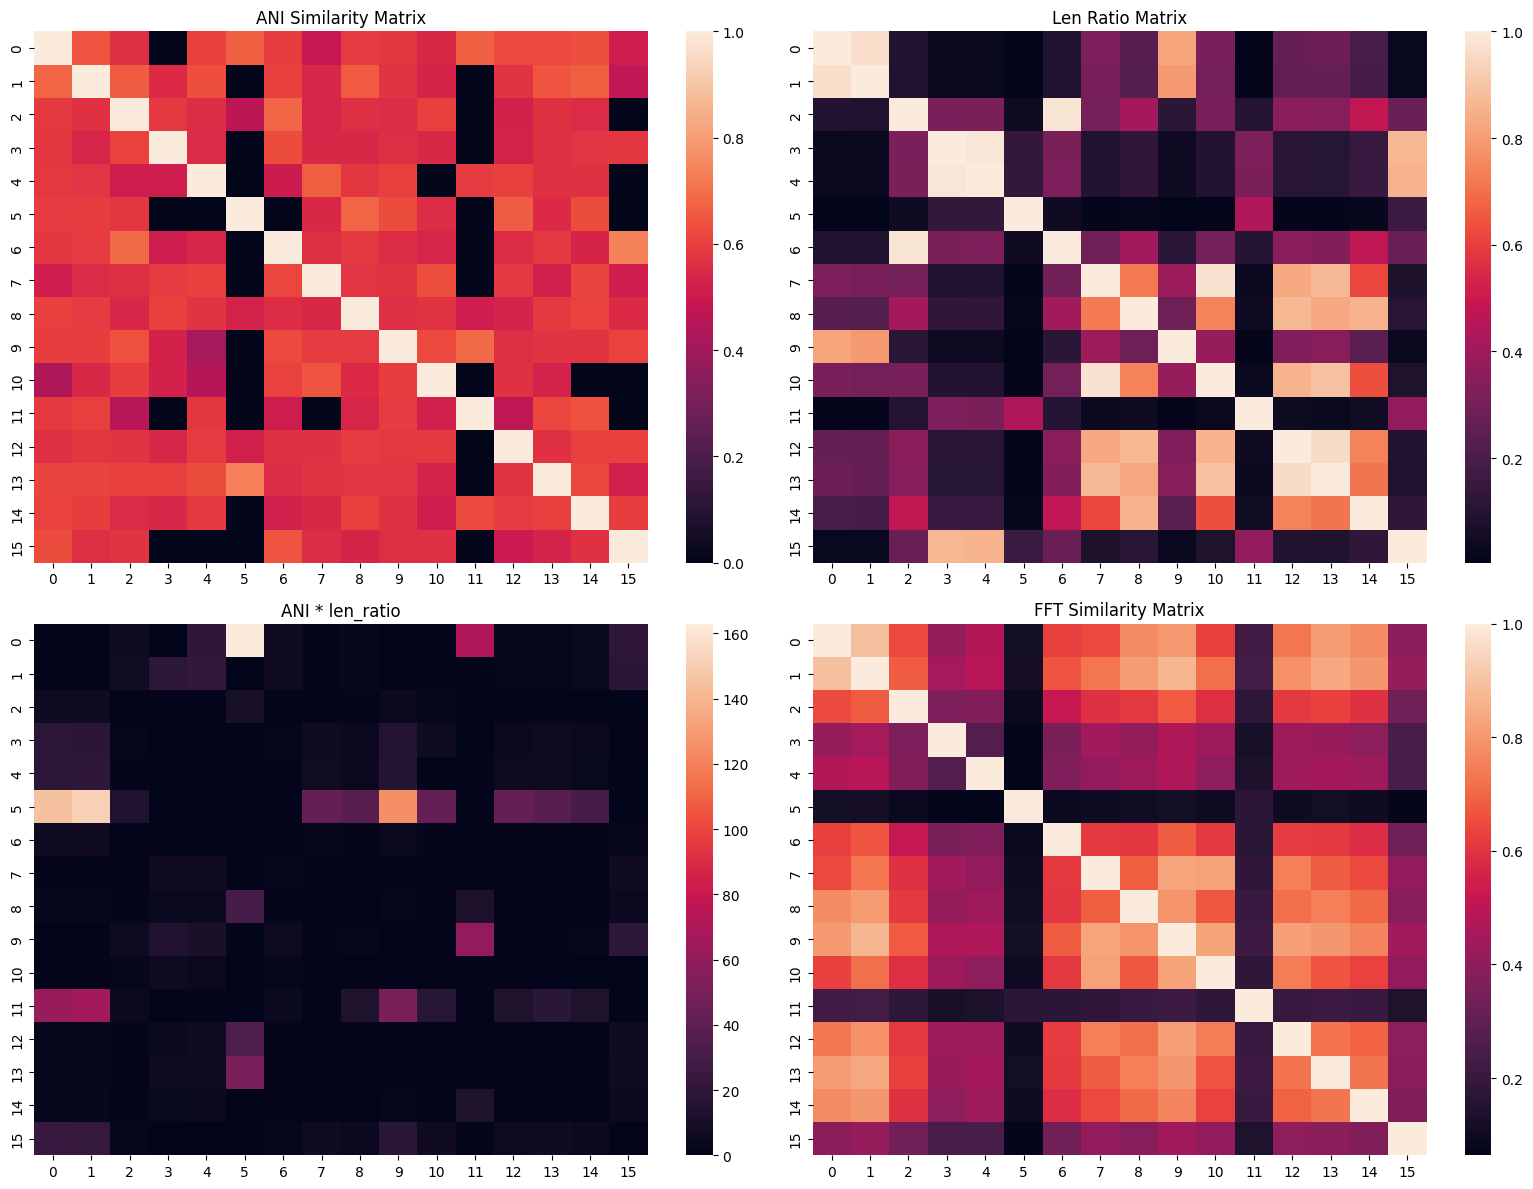

In [22]:
# sample_batch = next(iter(dataloader))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.heatmap(sample_batch["ani_mtx"], ax=axes[0][0], cbar=True)
sns.heatmap(sample_batch["wgt_mtx"], ax=axes[0][1], cbar=True)
sns.heatmap(sample_batch["ani_mtx"]/sample_batch["wgt_mtx"], ax=axes[1][0], cbar=True)
sns.heatmap(sample_batch["fft_mtx"], ax=axes[1][1], cbar=True)

axes[0][0].set_title("ANI Similarity Matrix")
axes[0][1].set_title("Len Ratio Matrix")
axes[1][0].set_title("ANI * len_ratio")
axes[1][1].set_title("FFT Similarity Matrix")
plt.tight_layout()
plt.show()

In [103]:
# pyro.render_model(vae.model,model_args=(sample_batch,))

In [104]:
# pyro.render_model(vae.guide,model_args=(sample_batch,))

In [ ]:
def get_learned_params(vae, batch):
    """
    Function to retrive the learned parameters for one pass
    """
    vae.encoder.eval()
    vae.decoder.eval()
    guide_trace = pyro.poutine.trace(vae.guide).get_trace(batch)
    trained_model = pyro.poutine.replay(vae.model, trace=guide_trace)
    trained_trace = pyro.poutine.trace(trained_model).get_trace(batch)
    params = trained_trace.nodes
    return params

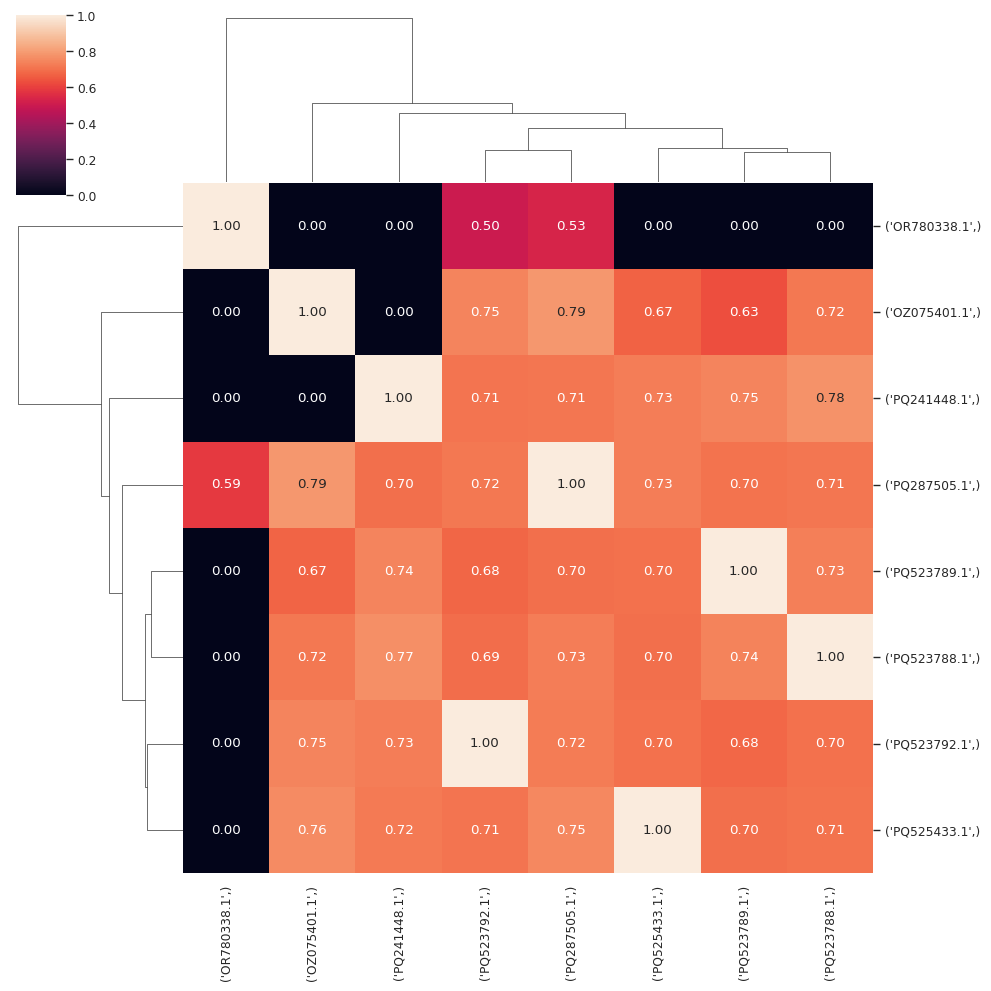

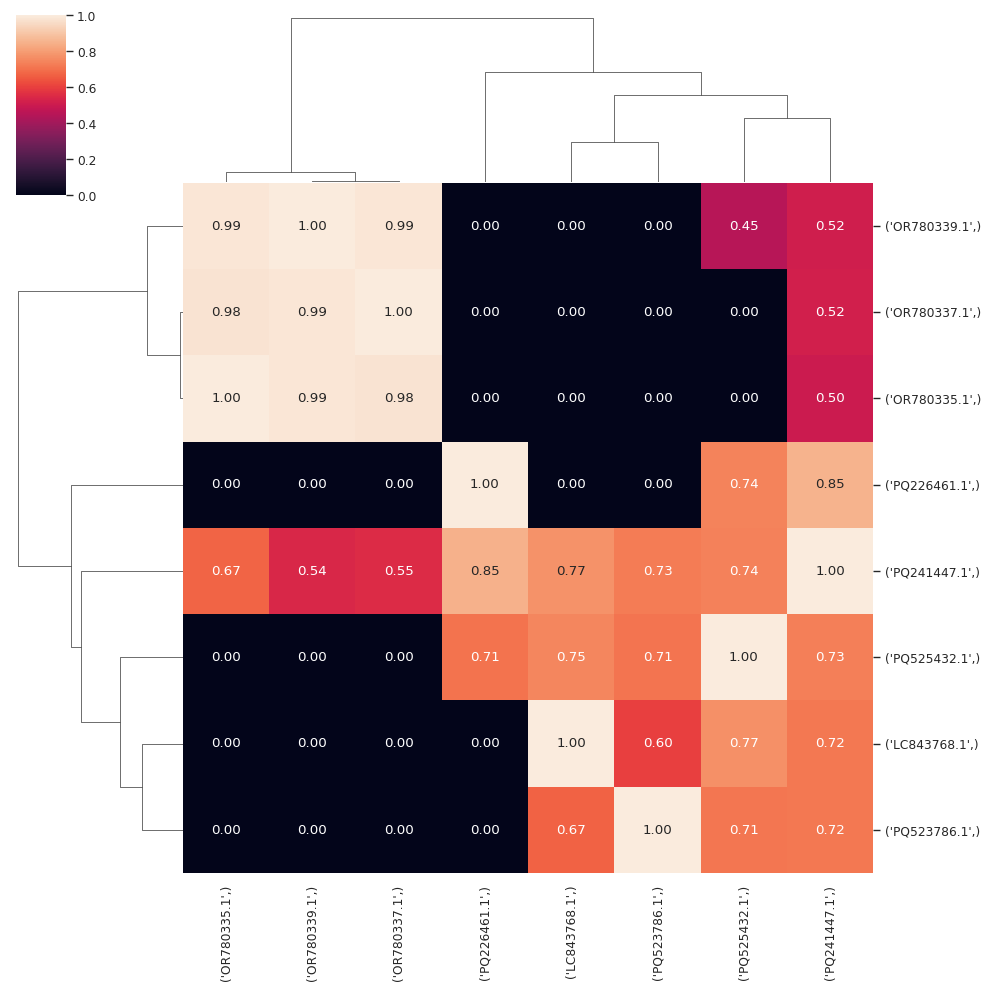

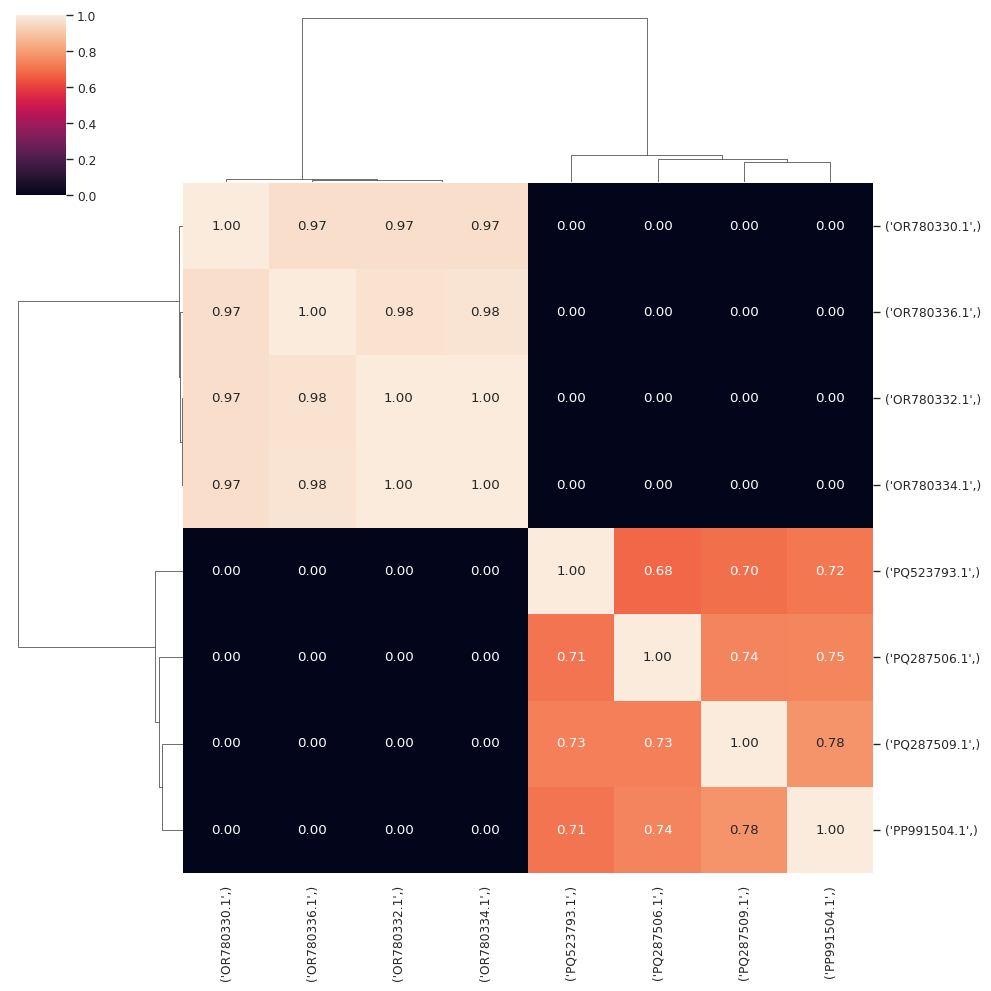

In [398]:
for batch in dataloader:
    fft_mtx = batch['ani_mtx']
    graphs = batch['graphs']
    headers = batch["headers"][0]
    headers = [tuple(s.split()[:2]) for s in headers]
    sim_df = pd.DataFrame(fft_mtx, columns=headers, index=headers)
    sns.clustermap(sim_df, annot=True, fmt=".2f",)
    plt.show()

In [336]:
# pyro.get_param_store().keys()

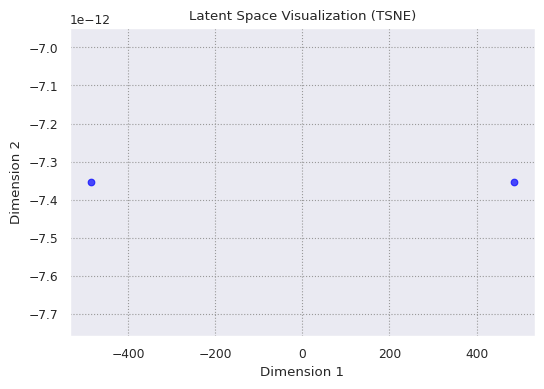

In [504]:
def visualize_latent_space(model, batch, method="pca"):
    """
    Visualize the latent space (eta) using PCA or t-SNE.
    """
    with torch.no_grad():
        eta_loc = pyro.param("eta_locs_q")
    if method.lower() == "pca":
        reduced = PCA(n_components=2).fit_transform(eta_loc.detach().numpy())
    elif method.lower() == "tsne":
        reduced = TSNE(n_components=2, perplexity=1).fit_transform(eta_loc.detach().numpy())
    else:
        raise ValueError("Method should be 'pca' or 'tsne'")
    
    plt.scatter(reduced[:, 0], reduced[:, 1], c="blue", alpha=0.7)
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
visualize_latent_space(vae, sample_batch, method="tsne")

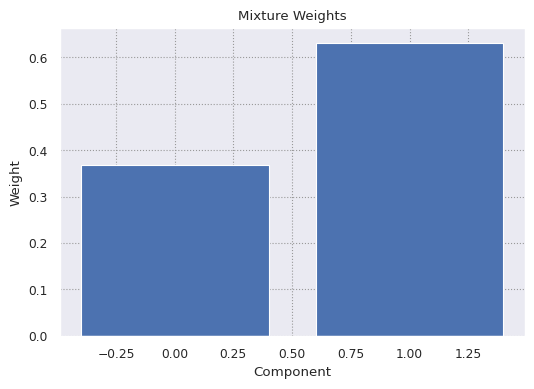

In [505]:
def plot_mixture_weights(model):
    """
    Plot the learned mixture weights.
    """
    weights = pyro.param("weights_q").detach().numpy()
    plt.bar(range(len(weights)), weights)
    plt.xlabel("Component")
    plt.ylabel("Weight")
    plt.title("Mixture Weights")
    plt.show()
plot_mixture_weights(vae)

In [506]:
from sklearn.metrics import precision_recall_fscore_support
from metagnn.tools.model.vae import batch_to_obs
def evaluate_reconstruction(model, batch):
    """
    Evaluate reconstruction quality by comparing true and reconstructed edges.
    """
    with torch.no_grad():
        _, decoded_edges = model.model(batch)
        edge_probas, edge_observations = batch_to_obs(decoded_edges, batch["graphs"])
    precision, recall, f1, _ = precision_recall_fscore_support(
        edge_observations.flatten(), (edge_probas > 0.5).to(int).flatten(), average="binary"
    )
    return {"precision": precision, "recall": recall, "f1": f1}
evaluate_reconstruction(vae, sample_batch)

{'precision': 0.3817785527462947,
 'recall': 0.22030487498113396,
 'f1': 0.2793887772354611}

In [507]:
def cluster_statistics(model, batch):
    """
    Summarize statistics for each cluster (mean and std of eta).
    """
    with torch.no_grad():
        eta_locs_q = pyro.param("eta_locs_q").detach().numpy()
        eta_scales_q = pyro.param("eta_scales_q").detach().numpy()
    stats = {
        f"Cluster {i}": {"mean": loc.tolist(), "std": scale.tolist()}
        for i, (loc, scale) in enumerate(zip(eta_locs_q, eta_scales_q))
    }
    return stats
cluster_statistics(vae, sample_batch)

{'Cluster 0': {'mean': [-0.2622309625148773, 0.20614008605480194],
  'std': [0.11464285105466843, 0.10348360985517502]},
 'Cluster 1': {'mean': [-0.3491024374961853, 0.6590079069137573],
  'std': [0.1006188839673996, 0.08769268542528152]}}

In [508]:
def feature_importances(model, batch):
    """
    Inspect features contributing most to cluster separations.
    """
    with torch.no_grad():
        eta_locs_q = pyro.param("eta_locs_q").detach()
    return torch.var(eta_locs_q, dim=0).numpy()
feature_importances(vae, sample_batch)

array([0.00377333, 0.10254463], dtype=float32)

(tensor([0, 1, 1, 0, 1, 1, 0, 1]),
 tensor([[0.3137, 0.6863],
         [0.5252, 0.4748],
         [0.1077, 0.8923],
         [0.1111, 0.8889],
         [0.1246, 0.8754],
         [0.0604, 0.9396],
         [0.4180, 0.5820],
         [0.1061, 0.8939]], requires_grad=True),
 [['PQ287509.1',
   'OR780332.1',
   'PQ287506.1',
   'OR780330.1',
   'OR780336.1',
   'PQ523793.1',
   'PP991504.1',
   'OR780334.1']])

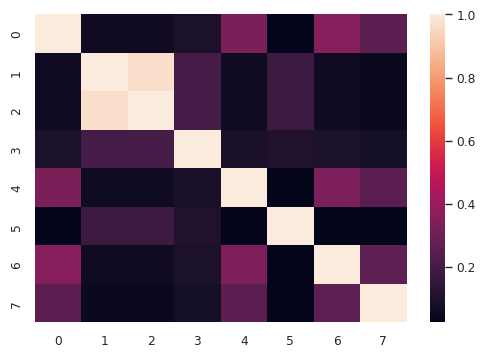

In [519]:
from pyro.infer import infer_discrete
import pyro.poutine as poutine

def classifier(vae, data, temperature=1):
    vae.eval()
    guide_trace = poutine.trace(vae._guide).get_trace(data)  # record the globals
    trained_model = poutine.replay(vae._model, trace=guide_trace)  # replay the globals
    
    inferred_model = infer_discrete(
        trained_model, temperature=temperature, first_available_dim=-2
    )
    sns.heatmap(sample_batch["fft_mtx"])
    
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["z"]["value"], guide_trace.nodes["z_probs"]["value"], batch["headers"]

classifier(vae, sample_batch)

In [520]:
for k in pyro.get_param_store().keys(): print(k) if "$" not in k else None

weights_q
eta_locs_q
eta_scales_q
z_probs


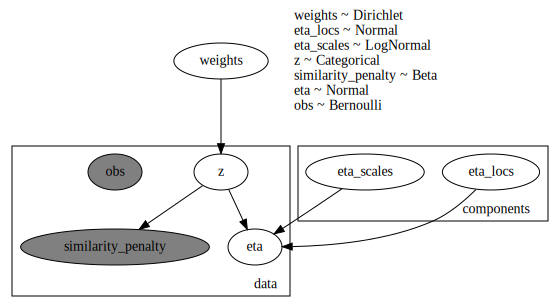

In [530]:
pyro.render_model(vae._model, model_args=(sample_batch,), render_distributions=True, render_params=False)

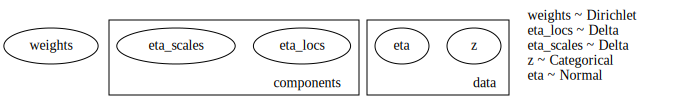

In [533]:
pyro.render_model(vae._guide, model_args=(sample_batch,), render_distributions=True, render_params=False)